In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Problem Setup

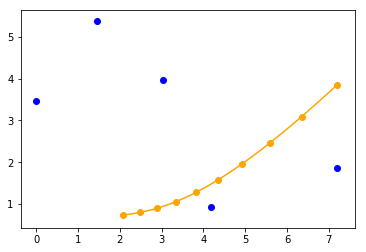

In [25]:
from trajectory import Trajectory
from environment import Environment
from global_variables import DIM

n_anchors = 5 #number of anchors
n_positions = 10 #number of robot sample positions
n_complexity = 4 #model complexity

trajectory = Trajectory(n_positions, n_complexity, model='polynomial')
environment = Environment(n_anchors)
trajectory.set_trajectory(seed=1)
environment.set_random_anchors(seed=1)


plt.figure()
environment.plot()
trajectory.plot(color='orange')
#plt.axis('off')
#plt.savefig('traj_setup.png')

environment.set_D(trajectory)
D_topright = environment.D[:n_positions,n_positions:] 

## SDP - based approach
### Noiseless case - single experiment

In [5]:
print("Make sure that your cvxpy version is >= 1.0.6!")
import cvxpy
print("Your version:", cvxpy.__version__)

from solvers import OPTIONS, semidefRelaxationNoiseless

# We cane change the global variable OPTIONS here. 

#OPTIONS[cvxpy.SCS]["max_iters"] = 200
# Seems to have no effect: 
#OPTIONS[cvxpy.SCS]["use_indirect"] = False 
# Seems to have no effect either: 
#OPTIONS[cvxpy.SCS]["eps"] = 1e-1
# Seems to have no effect either: 
#OPTIONS[cvxpy.SCS]["scale"] = 1

# Fails completely without this:
#OPTIONS[cvxpy.CVXOPT]["kktsolver"] = "robust"

# have no effect:
#OPTIONS[cvxpy.CVXOPT]["feastol"] = 1e-3
#OPTIONS[cvxpy.CVXOPT]["reltol"] = 1e-5
#OPTIONS[cvxpy.CVXOPT]["abstol"] = 1e-5

# leads to faster non-convergence: 
#OPTIONS[cvxpy.CVXOPT]["refinement"] = 0

#OPTIONS[cvxpy.SCS]["verbose"] = False
print(trajectory.basis.shape)

X = semidefRelaxationNoiseless(D_topright, environment.anchors, trajectory.basis, chosen_solver=cvxpy.CVXOPT)
print('should be identity:\n', X[:DIM, :DIM])
print('should be equal:\n', X[:DIM:, DIM:])
print(trajectory.coeffs)

Make sure that your cvxpy version is >= 1.0.6!
Your version: 1.0.14
(4, 10)
should be identity:
 [[ 1.00000000e+00 -1.26408554e-14]
 [-1.26408554e-14  1.00000000e+00]]
should be equal:
 [[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]
[[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]


### Noisy case - single experiment - NOT CURRENTLY WORKING

In [ ]:
from solvers import semidefRelaxation
from solvers import OPTIONS
#OPTIONS[cvxpy.SCS]["max_iters"] = 00

X = semidefRelaxation(D_topright, environment.anchors, trajectory.basis)

plt.matshow(X[:20, :20])
plt.colorbar()

plt.matshow(X[-20:, -20:])
plt.colorbar()

print('should be identity:\n', X[:DIM, :DIM])
print('should be equal:\n', X[DIM:, DIM:])
print(coeffs)

## Investigate null space

In [6]:
from constraints import *

ConstraintsMat, ConstraintsVec = get_constraints_matrix(D_topright, environment.anchors, trajectory.basis)
ConstraintsMat=np.array(ConstraintsMat)
ConstraintsVec=np.array(ConstraintsVec)

print(np.isclose(ConstraintsMat@trajectory.Z_opt.flatten(),ConstraintsVec))

print(ConstraintsMat.shape)
print(ConstraintsVec.shape)
u, s, vh = np.linalg.svd(ConstraintsMat, full_matrices=True)
print(np.around(s,3))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
(69, 36)
(69,)
[2.00150e+02 1.16084e+02 3.89970e+01 3.53780e+01 3.20720e+01 2.52020e+01
 2.06230e+01 1.87830e+01 1.71300e+01 8.72300e+00 5.45200e+00 4.44900e+00
 3.79700e+00 2.48400e+00 2.29000e+00 1.92200e+00 1.73200e+00 1.61700e+00
 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00
 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00 1.41400e+00
 1.41400e+00 1.41400e+00 6.80000e-02 0.00000e+00 0.00000e+00 0.00000e+00]


In [7]:
#construct right inverse and check meets constraints
num_zero_SVs = len(np.where(s<1e-10)[0])
Z_hat = vh[:-num_zero_SVs,:].T@np.diag(1/s[:-num_zero_SVs])@u[:,:len(s)-num_zero_SVs].T@ConstraintsVec #right inverse
Z_hat = Z_hat.reshape([DIM + n_complexity,DIM + n_complexity])
print(np.isclose(ConstraintsMat@Z_hat.flatten(),ConstraintsVec)) #should satisfy constraints since it's a right inverse
coeffs_hat = Z_hat[:DIM,DIM:]
print(np.isclose(trajectory.coeffs,coeffs_hat))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[[ True  True  True  True]
 [ True  True  True  True]]


In [8]:
print('find basis vectors of null space')
tmp = vh[-num_zero_SVs:,:]
print(tmp.shape)
nullSpace = []
for i in range(num_zero_SVs):
    nullSpace.append(tmp[i,:].reshape([DIM + n_complexity,DIM + n_complexity]))

nullSpace = np.array(nullSpace)
Z_hat2 = Z_hat+nullSpace[0,:]+2*nullSpace[1,:]+3*nullSpace[2,:]
print(np.isclose(ConstraintsMat@(Z_hat2.flatten()),ConstraintsVec))

find basis vectors of null space
(3, 36)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [9]:
print(np.around(nullSpace[0,:],5))
print(np.around(nullSpace[1,:],5))
print(np.around(nullSpace[2,:],5))

[[ 0.       0.       0.      -0.      -0.      -0.     ]
 [-0.       0.       0.      -0.       0.       0.     ]
 [-0.       0.       0.08391  0.04952 -0.27386  0.04952]
 [ 0.       0.       0.04952  0.46381 -0.09904  0.31581]
 [ 0.       0.      -0.27386 -0.09904 -0.63162  0.     ]
 [ 0.       0.       0.04952  0.31581  0.      -0.     ]]
[[-0.      -0.      -0.      -0.       0.       0.     ]
 [-0.      -0.      -0.       0.       0.       0.     ]
 [-0.      -0.      -0.36013 -0.20482 -0.09676 -0.20482]
 [ 0.      -0.      -0.20482  0.55365  0.40964 -0.08331]
 [ 0.       0.      -0.09676  0.40964  0.16661 -0.     ]
 [-0.       0.      -0.20482 -0.08331 -0.       0.     ]]
[[ 0.      -0.      -0.       0.      -0.       0.     ]
 [ 0.       0.      -0.      -0.       0.       0.     ]
 [ 0.       0.       0.3949  -0.19731  0.03171 -0.19731]
 [ 0.       0.      -0.19731 -0.45832  0.39462  0.16574]
 [-0.       0.       0.03171  0.39462 -0.33148  0.     ]
 [-0.      -0.      -0.19731 

### Solve as linear program

In [10]:
# try linear program
from cvxopt import matrix, solvers

tmpMat=np.diag(s[:-num_zero_SVs])@vh[:-num_zero_SVs,:]
tmpVec = u[:,:len(s)-num_zero_SVs].T@ConstraintsVec
A = matrix(np.vstack([tmpMat,-tmpMat]))
b = matrix(np.hstack([tmpVec,-tmpVec]))
c = matrix(np.ones((DIM + n_complexity)*(DIM + n_complexity)))
sol=solvers.lp(c,A,b, solver='glpk') #doesn't work eith defualt solver but glpk good
print(sol)
Z_hat = np.array(sol['x']).reshape([DIM + n_complexity,DIM + n_complexity])
print(np.isclose(Z_hat,trajectory.Z_opt))

{'primal objective': 90.78998261966927, 'x': <36x1 matrix, tc='d'>, 'status': 'optimal', 'dual slack': -1.1563634615430528e-14, 'primal slack': -8.526512829121202e-14, 'residual as dual infeasibility certificate': None, 'y': <0x1 matrix, tc='d'>, 'dual infeasibility': 9.938494408725894e-15, 'z': <66x1 matrix, tc='d'>, 'gap': -1.0370064487050049e-15, 'residual as primal infeasibility certificate': None, 'dual objective': 90.78998261966925, 's': <66x1 matrix, tc='d'>, 'primal infeasibility': 0.0, 'relative gap': -1.14220359866039e-17}
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True False False False False]
 [ True  True False False False False]
 [ True  True False False False  True]
 [ True  True False False  True  True]]


## MDS - based approach
### Noiseless case

In [11]:
# find new coefficients
from baseline_solvers import customMDS
coeffs_est = customMDS(D_topright, trajectory.basis, environment.anchors)
print(coeffs_est.shape)
print(coeffs_est)
print(trajectory.coeffs)

(2, 4)
[[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]
[[2.08511002e+00 3.60162247e+00 5.71874087e-04 1.51166286e+00]
 [7.33779454e-01 4.61692974e-01 9.31301057e-01 1.72780364e+00]]


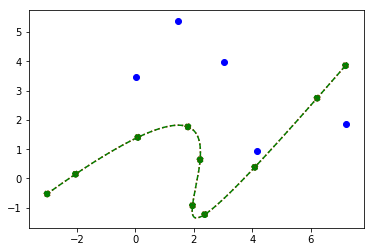

In [12]:
from trajectory import Trajectory
trajectory_est = Trajectory(n_positions, n_complexity)
trajectory_est.set_trajectory(coeffs=coeffs_est)

plt.figure()
environment.plot()
trajectory_est.plot(color='red', linestyle=':')
trajectory.plot(color='green', linestyle='--')

### Noisy case

In [13]:
from baseline_solvers import gradientDescent

sigma = 4

np.random.seed(1)
D_topright_noisy = D_topright + sigma * np.random.randn(*(D_topright.shape))
coeffs_est_noisy = customMDS(D_topright_noisy, trajectory.basis, environment.anchors)

coeffs_est_noisy, costs = gradientDescent(
    environment.anchors, trajectory.basis, coeffs_est_noisy, 
    D_topright_noisy,maxIters=50)
#print(checkStationaryPointSRLS(A,F,C_hat,DTR_tilde))
#plt.plot(costs)

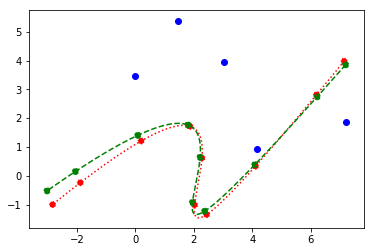

In [14]:
trajectory_est_noisy = Trajectory(n_positions, n_complexity)
trajectory_est_noisy.set_trajectory(coeffs=coeffs_est_noisy)

plt.figure()
environment.plot()
trajectory_est_noisy.plot(color='red', linestyle=':')
trajectory.plot(color='green', linestyle='--')

### Missing measurements

missing measurements between anchors, and between anchors and robot

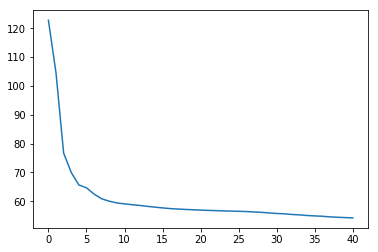

In [15]:
from baseline_solvers import alternateGDandKEonDR

np.random.seed(1)

sigma = 2
missing_proportion = 0.8

D_right = environment.D[:,n_positions:]
mask = np.ones(D_right.shape)

mask[:n_positions, :] *= (np.random.rand(n_positions,n_anchors)>missing_proportion)
D_right_missing = mask * D_right

# TODO: why are anchor positions not noisy? 
np.random.seed(1)
D_right_missing[:n_positions,:] += sigma * np.random.randn(n_positions, n_anchors)
D_right_est, errs = alternateGDandKEonDR(D_right_missing, mask, trajectory.basis, environment.anchors, 
                                         niter=40, DR_true=D_right)
plt.plot(errs)
coeffs_est_missing = customMDS(D_right_est[:n_positions,:], trajectory.basis, environment.anchors)
#print(C_hat)
#print(C)

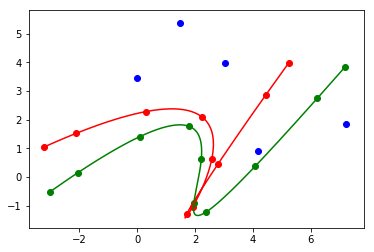

In [16]:
trajectory_est_missing = Trajectory(n_positions, n_complexity)
trajectory_est_missing.set_trajectory(coeffs=coeffs_est_missing)

plt.figure()
trajectory_est_missing.plot(color='red')
trajectory.plot(color='green')
environment.plot()

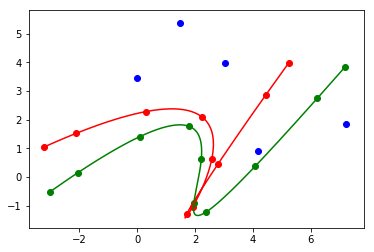

In [17]:
plt.figure()
trajectory_est_missing.plot(color='red', mask=mask)
trajectory.plot(color='green')
environment.plot()
#plt.axis('off')
#plt.savefig('traj_useful.png')

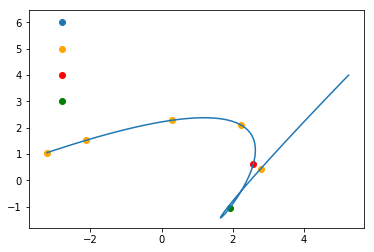

In [18]:
trajectory_est_missing.plot_number_measurements(mask=mask)

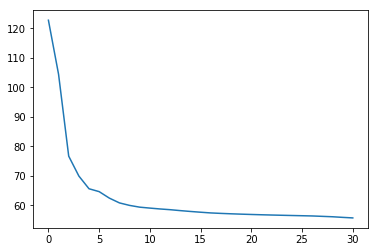

In [19]:
D_right_est, errs = alternateGDandKEonDR(D_right_missing, 
                                    mask, trajectory.basis, environment.anchors, 
                                    niter=30, DR_true=D_right)
plt.plot(errs)
coeffs_est = customMDS(D_right_est[:n_positions,:], trajectory.basis, environment.anchors)

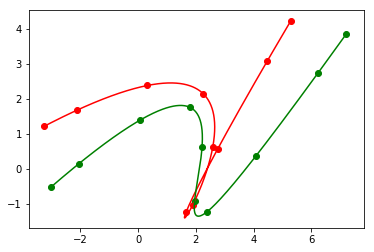

In [20]:
trajectory_est = Trajectory(n_positions, n_complexity)
trajectory_est.set_trajectory(coeffs=coeffs_est)

plt.figure()
trajectory_est.plot(color='red')
trajectory.plot(color='green')

In [21]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
tmp = D_right[:n_positions,:]
print(tmp[mask[:n_positions,:]==1])
print(mask[:n_positions,:]*tmp)

tmp = D_right_missing[:n_positions,:]
print(tmp[mask[:n_positions,:]==1])
print(mask[:n_positions,:]*tmp)

[13.97 8.33 35.32 40.09 3.90 23.08 6.08 4.21 39.35 110.37]
[[0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 13.97 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [8.33 35.32 0.00 0.00 40.09]
 [3.90 0.00 0.00 0.00 23.08]
 [0.00 0.00 6.08 0.00 0.00]
 [0.00 0.00 4.21 0.00 0.00]
 [39.35 0.00 0.00 0.00 0.00]
 [0.00 110.37 0.00 0.00 0.00]]
[13.20 6.13 37.61 41.90 2.53 24.14 4.70 4.68 38.96 110.75]
[[0.00 -0.00 -0.00 -0.00 0.00]
 [-0.00 0.00 -0.00 0.00 -0.00]
 [0.00 -0.00 -0.00 13.20 0.00]
 [-0.00 -0.00 -0.00 0.00 0.00]
 [6.13 37.61 0.00 0.00 41.90]
 [2.53 -0.00 -0.00 -0.00 24.14]
 [-0.00 -0.00 4.70 -0.00 -0.00]
 [-0.00 -0.00 4.68 0.00 0.00]
 [38.96 -0.00 -0.00 0.00 0.00]
 [-0.00 110.75 0.00 0.00 0.00]]
